 # IEEE-CIS Fraud Detection

Vesta Corporation provided the dataset for this model. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually. 

Problem: Binary classification with a heavy dataset imbalance

## Objective: Detect fraud in Transactions

### Data:  
  
``isFraud`` is the binary that denotes whether a transaction is fraud or not and this is the dependent variable to be modeled for  

Data is broken into two files ***identity*** and ***transaction***, these can be join by the ``TransactioID``  
  
***Identity Categorical Features***
* DeviceType
* DeviceInfo
* id_12-id_38
  
***Transaction Categorical Features***
* Product CD
* emaildomain
* card1-card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1-M9

The ``TransactionDT`` feature is a timedelta from a given reference datetime (not an actual timestamp).


## Import Required Modules

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
# Functions

def detect_outlier(data):
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std = np.std(data)
    
    for value in data:
        z_score = (value-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(value)
    return outliers

def distribution_fraud_percent(df, feature, bins):
    fig, ax1 = plt.subplots(figsize=(20, 5)) 

    (n1, bins1, patches1) = plt.hist(df.sort_values(feature)[feature], color='tab:green', bins=bins, alpha=0.5)
    (n2, bins2, patches2) = plt.hist(df.loc[df['isFraud']==1].sort_values(feature)[feature], bins=bins)
    heights1 = pd.Series(n1)
    heights2 = pd.Series(n2)
    heights = pd.concat([heights1, heights2], axis=1)
    heights['percent_fraud'] = (heights[1] / (heights[0] + heights[1]))*100
    center = (bins1[1] - bins1[0])/2
    heights['bins'] = (bins1[:-1] + center)

    ax1.set_title(f'{feature} Distribution')
    ax1.set_xlabel(f'{feature}') 
    ax1.set_ylabel('Count', color = 'tab:green') 
    ax1.hist(train.sort_values(feature)[feature], bins=bins, color='tab:green', alpha=0.5)
    ax1.tick_params(axis ='y', labelcolor = 'tab:green') 

    ax2 = ax1.twinx() 

    color = 'tab:red'
    ax2.set_ylabel('%Fraud', color = 'tab:red') 
    ax2.plot(heights['bins'], heights['percent_fraud'], color = 'tab:red', marker='o') 
    ax2.tick_params(axis ='y', labelcolor = 'tab:red')
    
    plt.show()
    
def cat_fraud_percent(df, feature):
    cat_size = df.groupby(feature).size()
    cat_fraud_size = df.loc[df['isFraud']==1].groupby(feature).size()

    cat_fraud_size = pd.DataFrame(cat_fraud_size)
    cat_fraud_size = cat_fraud_size.rename(columns={0: 'count_fraud'})

    cat_size = pd.DataFrame(cat_size)
    cat_size = cat_size.rename(columns={0: 'count'})

    df_merge = cat_size.merge(cat_fraud_size, how='outer', left_index=True, right_index=True)
    df_merge = df_merge.fillna(0.0)
    df_merge['percent_fraud'] = \
        (df_merge['count_fraud'] / (df_merge['count_fraud'] + df_merge['count']))*100

    fig, ax1 = plt.subplots(figsize=(20, 7))

    sns.barplot(x=df_merge.index, y=df_merge['count'], alpha=0.5, ax=ax1)
    ax1.tick_params(labelrotation=90)

    ax1.set_title(f'{feature}')

    ax2 = ax1.twinx()

    sns.lineplot(x=np.arange(0,len(df_merge.index)), y=df_merge['percent_fraud'], marker='o', ax=ax2)
    ax2.tick_params(labelrotation=90)
    
    plt.show()
    
def size_and_percentage(df, feature):
    feature_size = df.groupby(f'{feature}', dropna=False).size().sort_values(ascending=False)
    feature_size = pd.DataFrame(feature_size)
    feature_size.rename(columns={0: 'size'}, inplace=True)
    total = feature_size['size'].sum()
    feature_size['percentage'] = (feature_size['size']/total)*100
    return feature_size

## Load the Dataset

In [3]:
FOLDER_PATH = 'ieee-fraud-detection'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [4]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis

In [8]:
print(f'Train Columns w/ missing data: {train.isna().any().sum()}')

Train Columns w/ missing data: 414


In [9]:
missing_values = train.isnull().sum()
print(missing_values[:15])

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
dtype: int64


In [10]:
total_cells = np.product(train.shape)
missing_count = missing_values.sum()
print(f'{total_cells/missing_count: .2f}% mising data')

 2.22% mising data


In [11]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [13]:
fraud_count = pd.DataFrame(train.isFraud.value_counts())
fraud_count = fraud_count.reset_index()
print(fraud_count)
no_fraud = fraud_count['isFraud'][0]
fraud = fraud_count['isFraud'][1]
print(f'Fraud Percentage: {(fraud / (no_fraud + fraud)) * 100: .2f}%')

   index  isFraud
0      0   569877
1      1    20663
Fraud Percentage:  3.50%


<Figure size 1152x432 with 0 Axes>

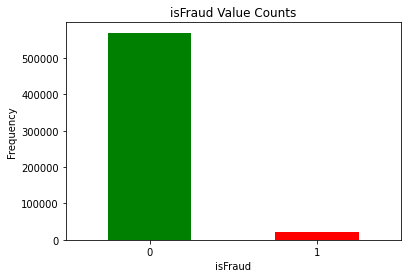

In [14]:
plt.figure(figsize=(16,6))
fraud_count.plot(x='index', y='isFraud', kind='bar', legend=False, color=['green', 'red'], rot=0)
plt.xlabel('isFraud')
plt.ylabel('Frequency')
plt.title('isFraud Value Counts')
plt.show()

In [15]:
train.TransactionAmt.describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

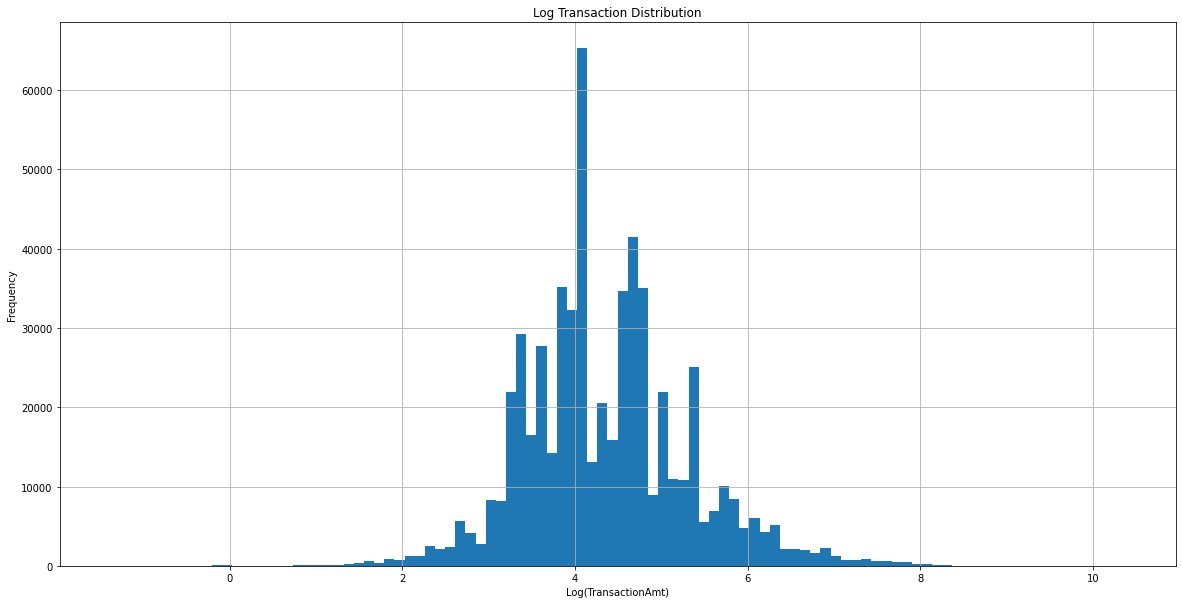

In [16]:
plt.figure(figsize=(20,10))
train['log_trans_amt'] = np.log(train['TransactionAmt'])
train['log_trans_amt'].hist(bins=100)
plt.xlabel('Log(TransactionAmt)')
plt.ylabel('Frequency')
plt.title('Log Transaction Distribution')

plt.show()

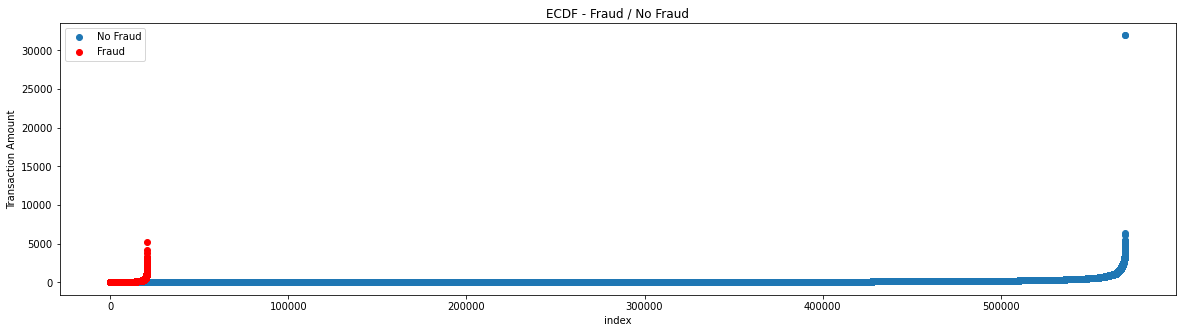

In [17]:
plt.figure(figsize=(20,5))
plt.scatter(train.loc[train['isFraud'] == 0].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 0][['TransactionAmt']].sort_values('TransactionAmt'), label='No Fraud')
plt.scatter(train.loc[train['isFraud'] == 1].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 1][['TransactionAmt']].sort_values('TransactionAmt'), color='red', label = 'Fraud')
plt.xlabel('index')
plt.ylabel('Transaction Amount')
plt.title('ECDF - Fraud / No Fraud')
plt.legend()
plt.show()

This demonstrates that most fraud has low Transaction amounts. Similar ECDF shape to the no fraud shape

Text(0.5, 1.0, 'ECDF - Fraud')

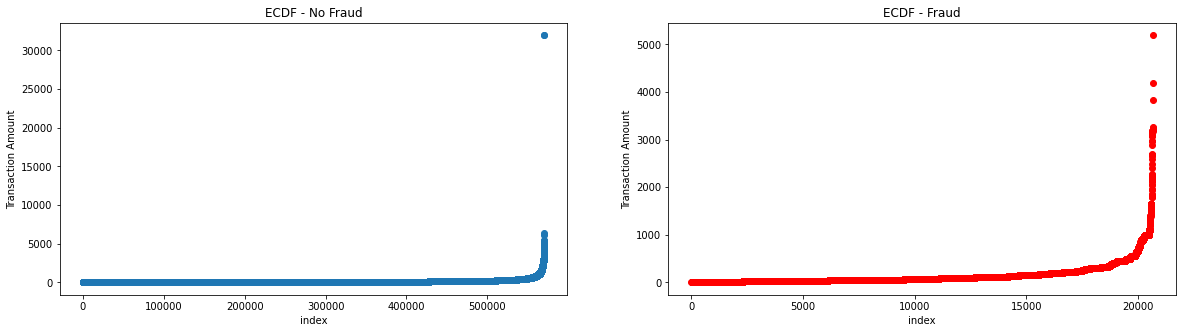

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax1.scatter(train.loc[train['isFraud'] == 0].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 0][['TransactionAmt']].sort_values('TransactionAmt'), label='No Fraud')
ax1.set_xlabel('index')
ax1.set_ylabel('Transaction Amount')
ax1.set_title('ECDF - No Fraud')

ax2.scatter(train.loc[train['isFraud'] == 1].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 1][['TransactionAmt']].sort_values('TransactionAmt'), color='red', label = 'Fraud')
ax2.set_xlabel('index')
ax2.set_ylabel('Transaction Amount')
ax2.set_title('ECDF - Fraud')

### Quantiles of Fraud and No Fraud Transactions

In [19]:
print('Quantiles of Fraud')
print(train.loc[train['isFraud'] == 1]['TransactionAmt'].quantile([0.01, 0.1, 0.24, 0.5, 0.75, 0.9]).reset_index())

Quantiles of Fraud
   index  TransactionAmt
0   0.01         6.74096
1   0.10        18.93600
2   0.24        34.00000
3   0.50        75.00000
4   0.75       161.00000
5   0.90       335.00000


In [20]:
print('Quantiles of No Fraud')
print(train.loc[train['isFraud'] == 0]['TransactionAmt'].quantile([0.01, 0.1, 0.24, 0.5, 0.75, 0.9]).reset_index())

Quantiles of No Fraud
   index  TransactionAmt
0   0.01         9.51288
1   0.10        26.31000
2   0.24        40.95000
3   0.50        68.50000
4   0.75       120.00000
5   0.90       267.11200


#### TansactionAMT Outliers

In [21]:
amt_outliers = detect_outlier(train['TransactionAmt'])
print(f'TransactionAmt Outlier Count: {len(amt_outliers)}')
non_outlier_cnt = len(train['TransactionAmt'])-len(amt_outliers)
print(f'TransactionAmt Non-Outlier Count: {non_outlier_cnt}')

TransactionAmt Outlier Count: 10093
TransactionAmt Non-Outlier Count: 580447


### Product Feature

ProductCD: product code, the product for each transaction \
Explore the ProductCD Feature (part of the transactions data)

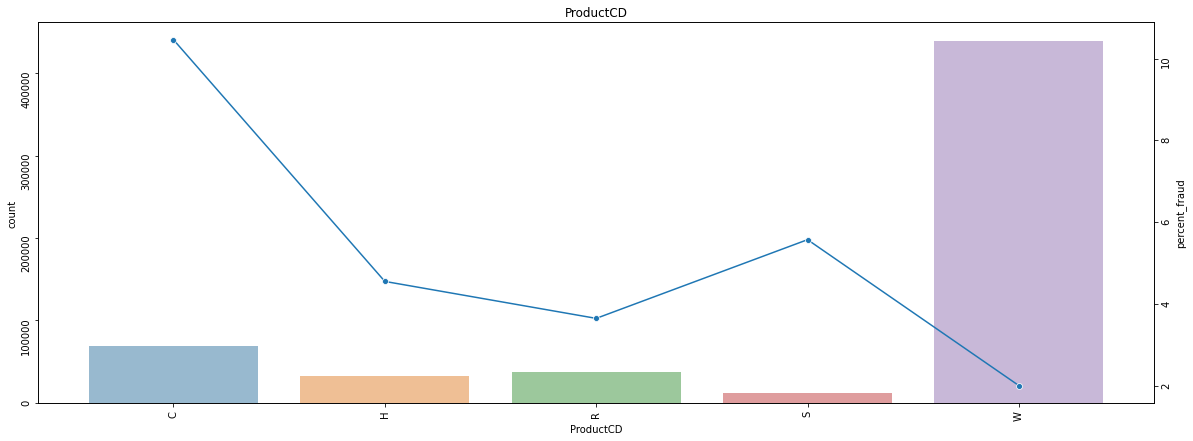

In [22]:
cat_fraud_percent(train, 'ProductCD')

C and W are the most common fraud cases. W is the most common overall ProductCD so it makes sense that it will also be a common fraud case. C only accounts for 11% of the total ProductCD, but it accounts for around 40% of the total fraud cases.

### Card Feature

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc. \
(part of the transactions data)

In [23]:
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
train[card_features].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


All of these feautres identify the card information that is used for the transaction

***Debit vs Credit***

Text(0.5, 1.0, 'Fraud Card6')

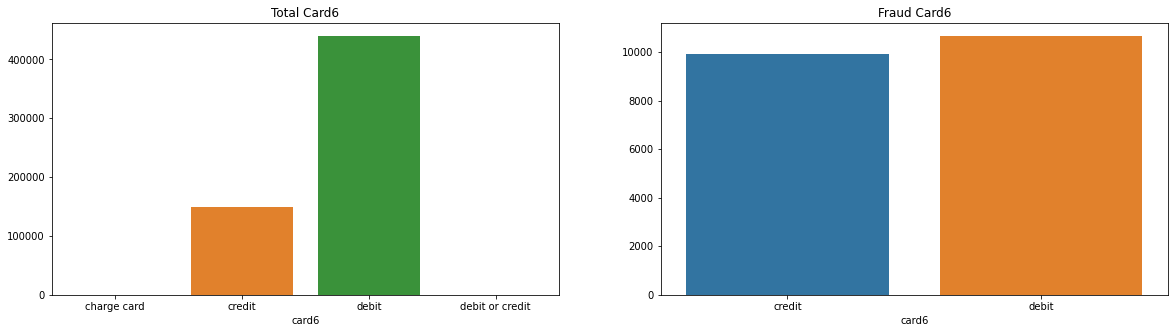

In [24]:
f, axes = plt.subplots(1, 2, figsize=(20,5))

card6_size = train.groupby('card6').size()
card6_fraud_size = train.loc[train['isFraud']==1].groupby('card6').size()

sns.barplot(x=card6_size.index, y=card6_size.values, ax=axes[0])
sns.barplot(x=card6_fraud_size.index, y=card6_fraud_size.values, ax=axes[1])

axes[0].set_title('Total Card6')
axes[1].set_title('Fraud Card6')

***Card Company***

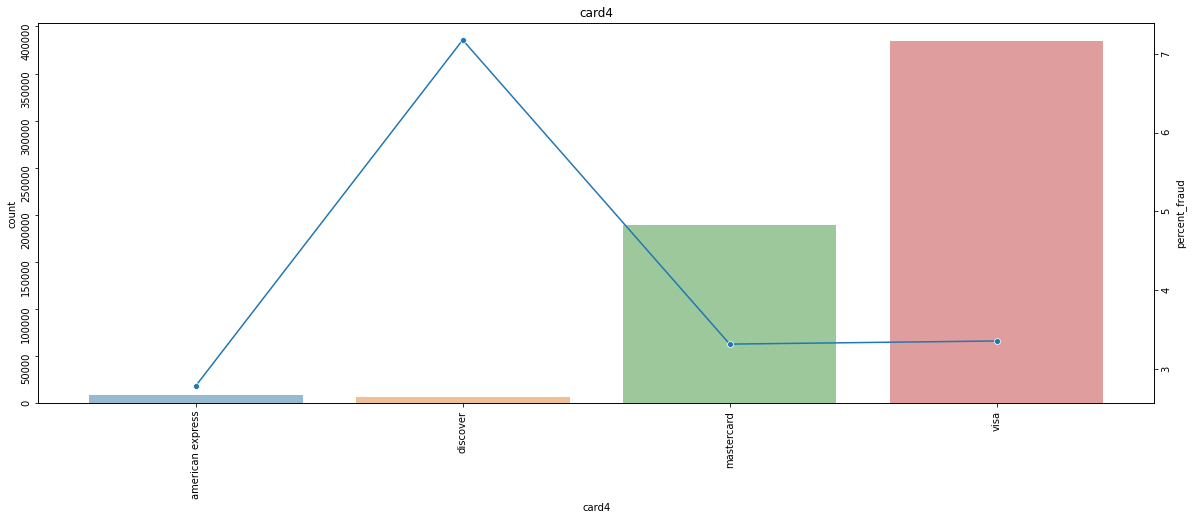

In [25]:
cat_fraud_percent(train, 'card4')

Discover seems to have a higher likelyhood of fraud compared to the others

***Card 1, 2, 3, and 5 Distributions***

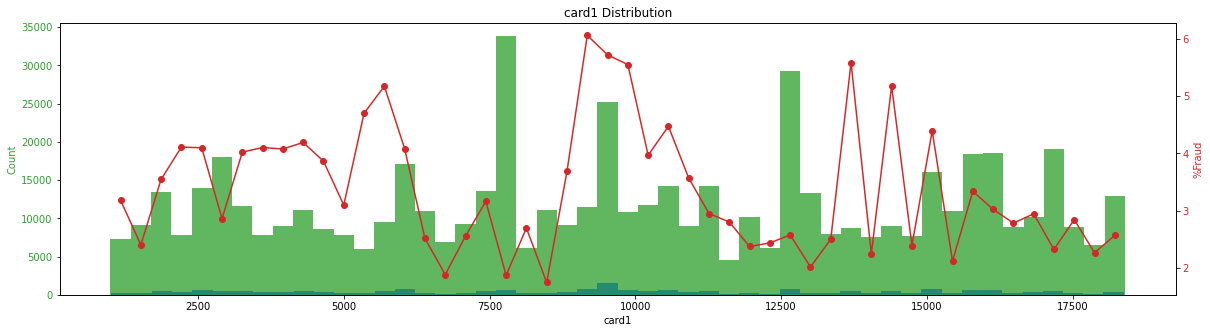

In [26]:
distribution_fraud_percent(train, 'card1', bins=50)

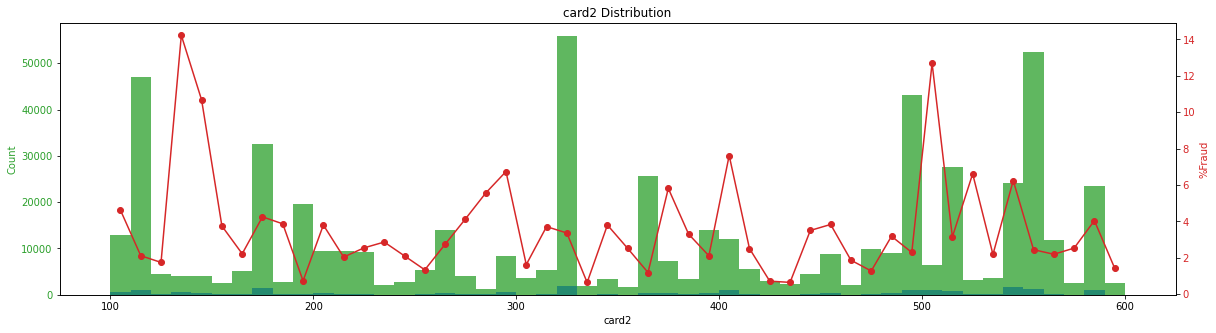

In [27]:
distribution_fraud_percent(train, 'card2', bins=50)

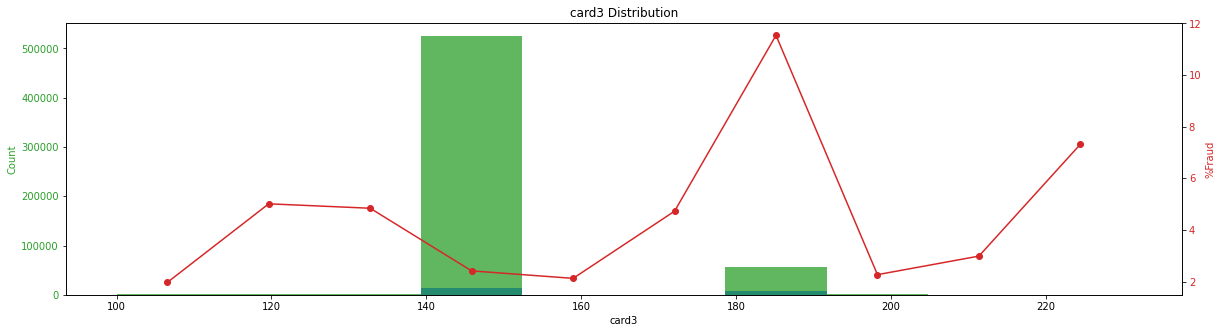

In [28]:
distribution_fraud_percent(train, 'card3', bins=10)

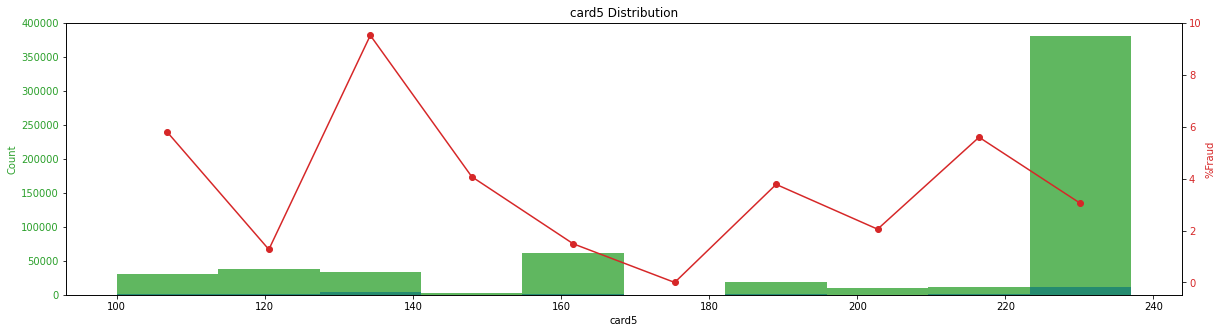

In [29]:
distribution_fraud_percent(train, 'card5', bins=10)

### Addr Feature

In [30]:
addr_features = ['addr1', 'addr2']
train[addr_features].head()

,addr1,addr2
0,315.0,87.0
1,325.0,87.0
2,330.0,87.0
3,476.0,87.0
4,420.0,87.0


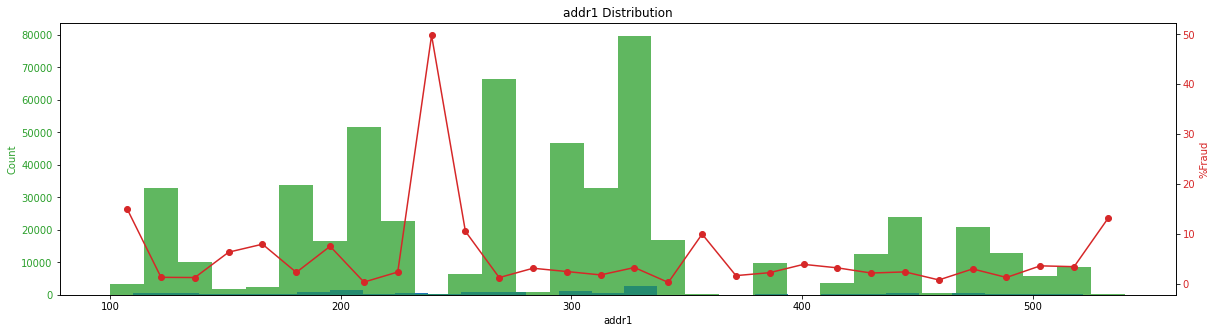

In [31]:
distribution_fraud_percent(train, 'addr1', bins=30)

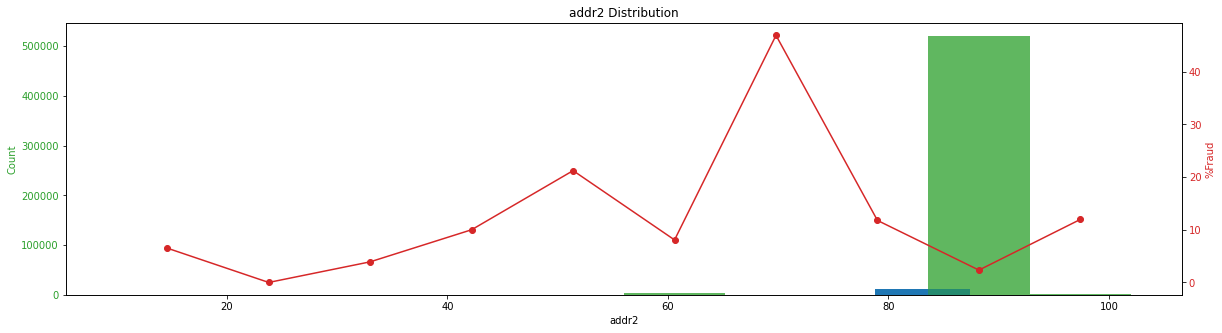

In [32]:
distribution_fraud_percent(train, 'addr2', bins=10)

### Email Domain Feature

P_ and (R__) emaildomain: purchaser and recipient email domain

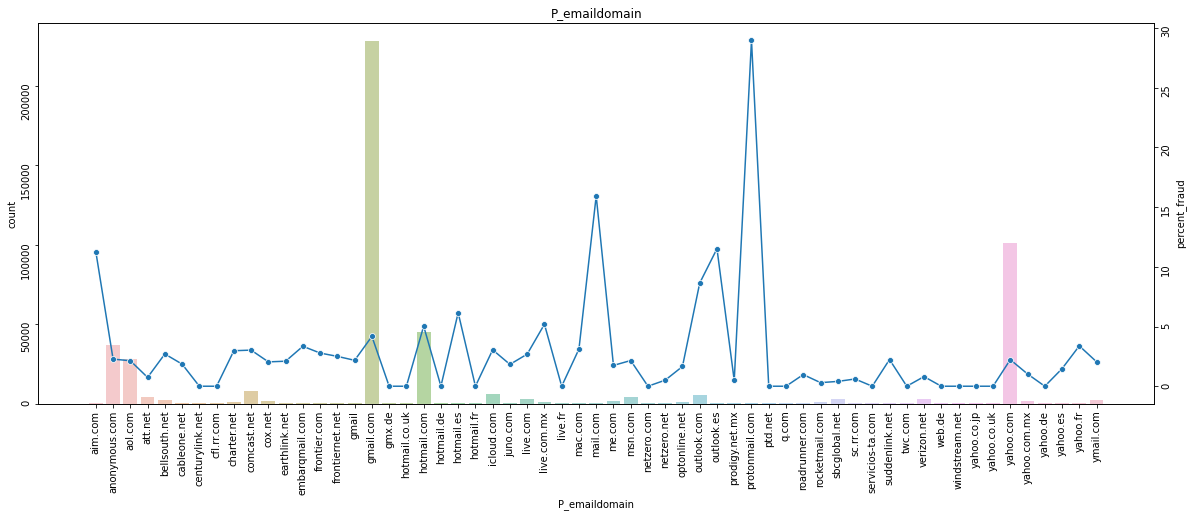

In [33]:
cat_fraud_percent(train, 'P_emaildomain')

Some domains that have a small total size seem to have a higher chance of fraud

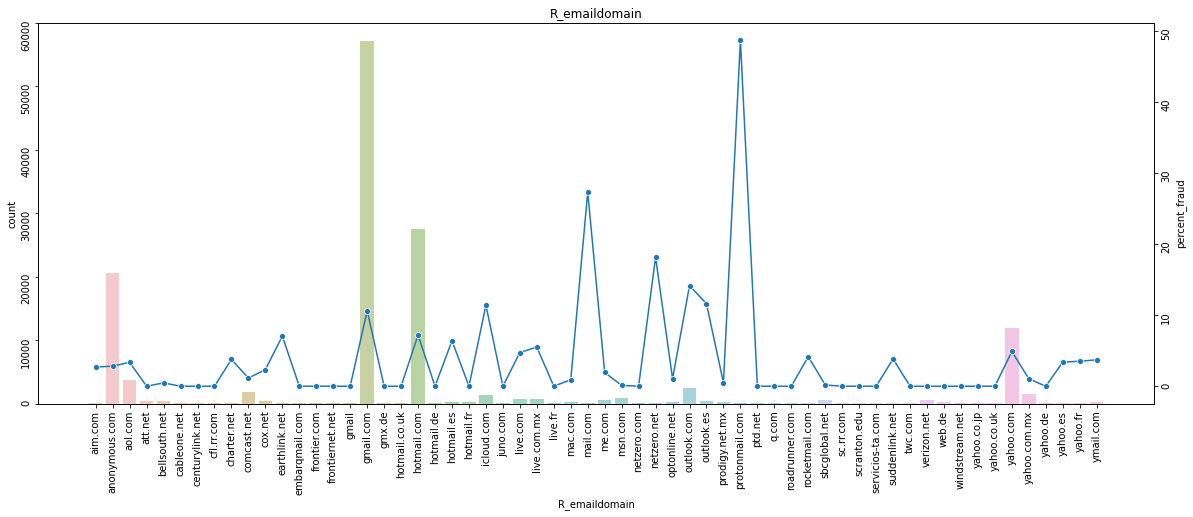

In [34]:
cat_fraud_percent(train, 'R_emaildomain')

Some domains that have a small total size seem to have a higher chance of fraud

### Device Feature

In [35]:
device_feature = ['DeviceType', 'DeviceInfo']
train[device_feature].head()

,DeviceType,DeviceInfo
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,mobile,SAMSUNG SM-G892A Build/NRD90M


In [36]:
train.groupby('DeviceType', dropna=False).size()

DeviceType
desktop     85165
mobile      55645
NaN        449730
dtype: int64

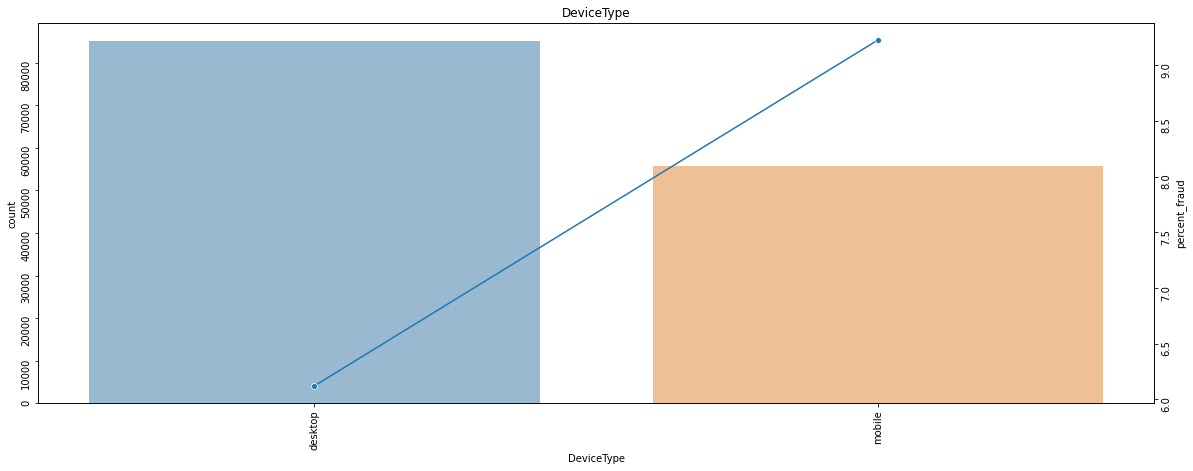

In [37]:
cat_fraud_percent(train, 'DeviceType')

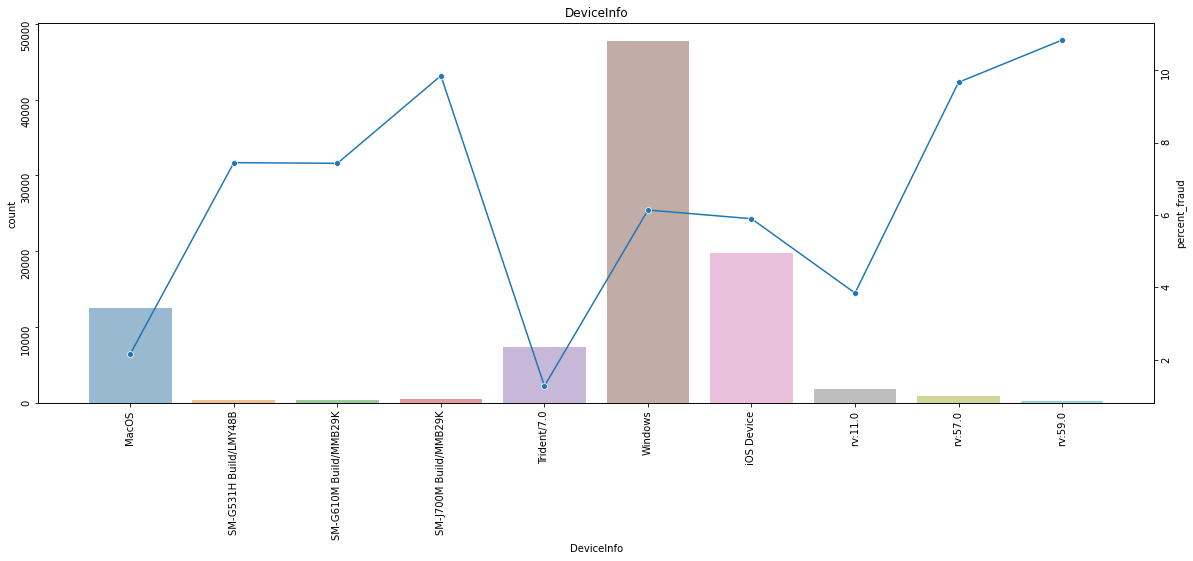

In [38]:
top_10_devices = train.groupby('DeviceInfo').size().sort_values(ascending=False)[:10]
top_10_devices = top_10_devices.reset_index()
top_10_devices = list(top_10_devices['DeviceInfo'])
#plot only the top 10 devices
cat_fraud_percent(train.loc[train['DeviceInfo'].isin(top_10_devices)], 'DeviceInfo')

### Explor Time distribution of Test and Train Data

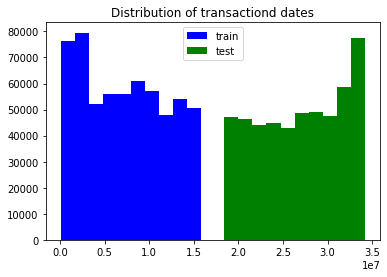

In [39]:
plt.hist(train['TransactionDT'], label='train', color='blue');
plt.hist(test['TransactionDT'], label='test', color='green');
plt.legend();
plt.title('Distribution of transactiond dates');

The train transaction datetime and the test transaction datetime do not overlap. Need to use time-based plit for validation. 
This was initially pointed out in the following kernel:  https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

### ID Feature

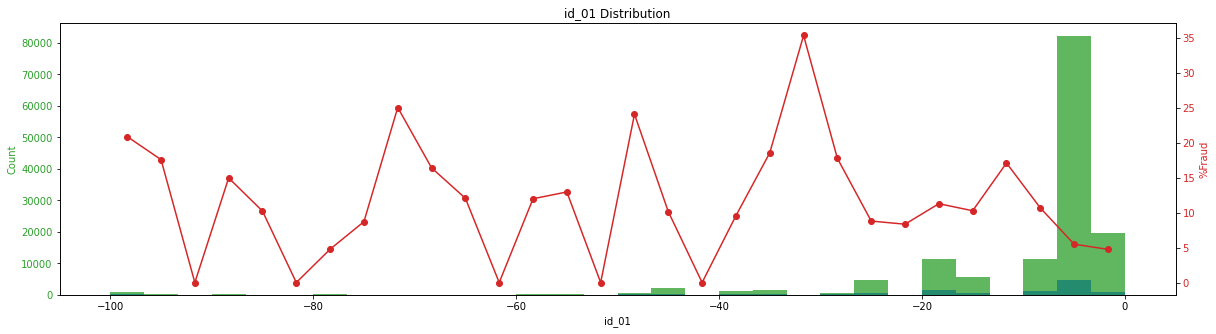

In [40]:
# id_01
distribution_fraud_percent(train, 'id_01', bins=30)

In [41]:
id_03_size = size_and_percentage(train, 'id_03')
print(id_03_size.head())

         size  percentage
id_03                    
NaN    524216   88.768923
0.0     63903   10.821113
1.0       863    0.146137
3.0       668    0.113117
2.0       421    0.071291


In [42]:
id_11_size = size_and_percentage(train, 'id_11')
print(id_11_size.head())

              size  percentage
id_11                         
NaN         449562   76.127273
100.000000  133162   22.549192
95.080002     1231    0.208453
95.160004      754    0.127680
97.120003      440    0.074508


MORE EDA IS NEEDED

## Feature Engineering

In [43]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['Weekdays'] = train['Date'].dt.dayofweek
train['Hours'] = train['Date'].dt.hour
train['Days'] = train['Date'].dt.day

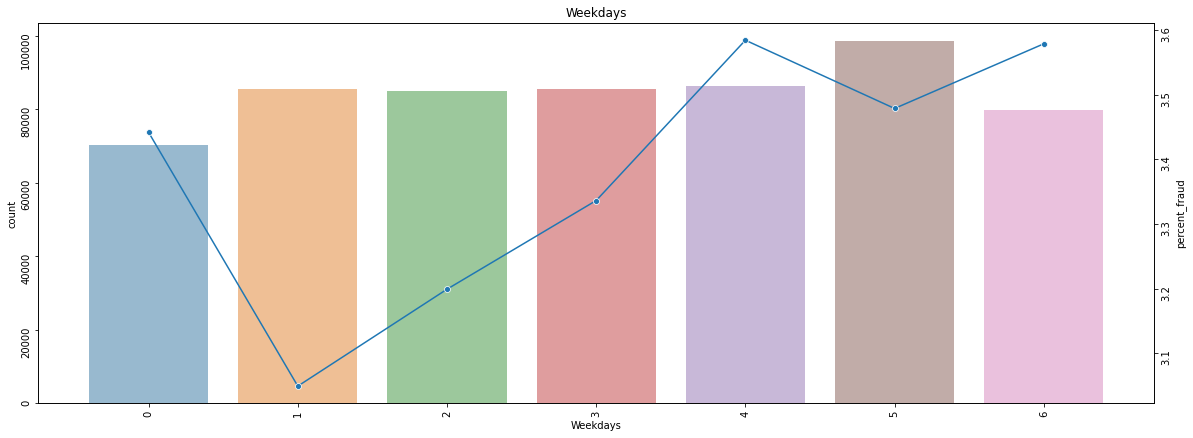

In [44]:
cat_fraud_percent(train, 'Weekdays')

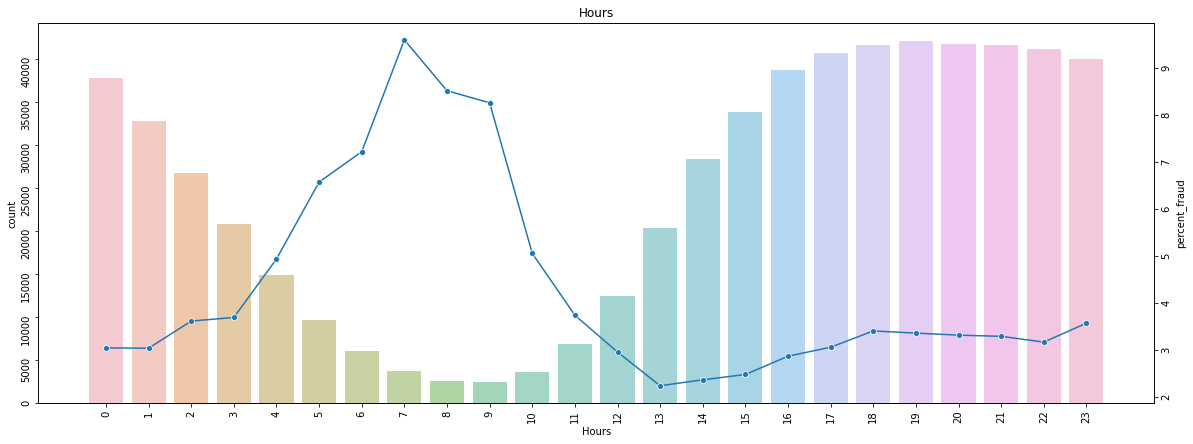

In [45]:
cat_fraud_percent(train, 'Hours')

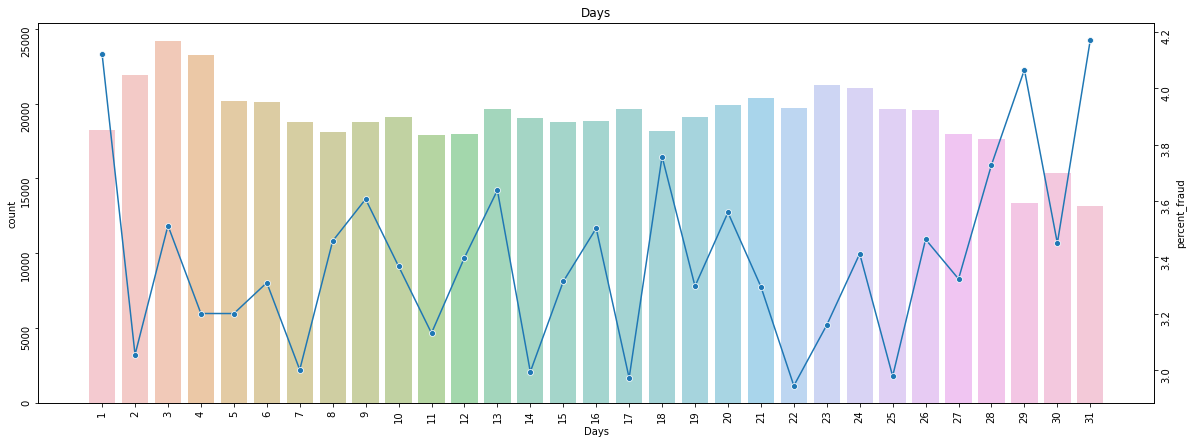

In [46]:
cat_fraud_percent(train, 'Days')

MORE FEATURE ENGINEERING IS REQUIRED

## Prepare for Modeling

***Dropping Bad Columns***

In [47]:
row_count = train.shape[0]

In [48]:
# get a list of columns with over 90% null values
nan_col = [col for col in train.columns if (train[col].isnull().sum() / row_count) > 0.9]
nan_col_test = [col for col in test.columns if (test[col].isnull().sum() / row_count) > 0.9]
# get a list of columns that are dominated by one value
vast_majority_col = [col for col in train.columns \
                           if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
vast_majority_col_test = [col for col in test.columns \
                           if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [49]:
drop_cols = nan_col + nan_col_test + vast_majority_col + vast_majority_col_test
drop_cols.remove('isFraud')

In [50]:
train_drop = list(set(pd.Series(drop_cols).str.replace('-', '_')))
test_drop = list(set(pd.Series(drop_cols).str.replace('_', '-')))
print(f'Dropping {len(train_drop)} columns from the dataframe')

Dropping 82 columns from the dataframe


In [51]:
train.drop(train_drop, axis=1, inplace=True)
test.drop(test_drop, axis=1, inplace=True)

***Categorical Feature Encoding***

In [52]:
train_cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', \
            'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', \
            'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', \
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', \
            'P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5',\
            'card6', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
           ]
test_cat_cols = list(pd.Series(train_cat_cols).str.replace('id_', 'id-'))

In [53]:
from sklearn.preprocessing import LabelEncoder
for i in range(len(train_cat_cols)):
    if train_cat_cols[i] in train.columns:
        le = LabelEncoder()
        le.fit(list(train[train_cat_cols[i]].astype(str).values) + list(test[test_cat_cols[i]].astype(str).values))
        train[train_cat_cols[i]] = le.transform(list(train[train_cat_cols[i]].astype(str).values))
        test[test_cat_cols[i]] = le.transform(list(test[test_cat_cols[i]].astype(str).values))   

In [54]:
# set up X train and y train
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID', 'Date'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

***Clean Missing Values***

In [55]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [56]:
import gc
gc.collect()

45

### Modeling

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [68]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

XGBOOST

In [58]:
import xgboost as xgb

In [59]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.03,
    n_estimators=1000,
    max_depth = 5,
    min_child_weight=1,
    subsample=0.8,
    objective='reg:logistic',
    eval_metric='auc',
)
xgb_clf.fit(X_train, y_train)

C:\Users\JSPANGLER\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

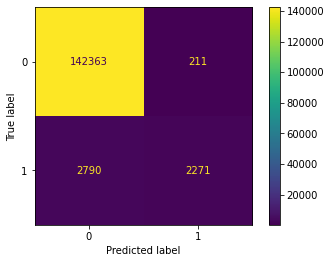

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142574
           1       0.91      0.45      0.60      5061

    accuracy                           0.98    147635
   macro avg       0.95      0.72      0.80    147635
weighted avg       0.98      0.98      0.98    147635



In [71]:
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

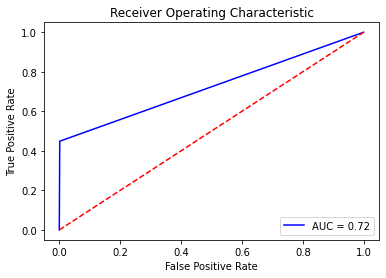

In [72]:
buildROC(y_test, y_pred)

Terrible Recall on this model. A Dummy variable that gueses no fraud every time would do just as well or even better

CAT BOOST

In [60]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from catboost.utils import get_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [61]:
cb_params={
    'learning_rate':0.03,
    'iterations': 50,
    'depth':13,
    'verbose':10
}

cb_clf = CatBoostClassifier(**cb_params)
cb_clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
)

0:	learn: 0.6422371	test: 0.6423315	test1: 0.6423109	best: 0.6423109 (0)	total: 5.79s	remaining: 4m 43s
10:	learn: 0.3244578	test: 0.3244679	test1: 0.3240805	best: 0.3240805 (10)	total: 1m 1s	remaining: 3m 38s
20:	learn: 0.1982313	test: 0.1983119	test1: 0.1977608	best: 0.1977608 (20)	total: 1m 53s	remaining: 2m 37s
30:	learn: 0.1446114	test: 0.1447015	test1: 0.1443361	best: 0.1443361 (30)	total: 2m 46s	remaining: 1m 42s
40:	learn: 0.1204095	test: 0.1204868	test1: 0.1203903	best: 0.1203903 (40)	total: 3m 39s	remaining: 48.2s
49:	learn: 0.1087083	test: 0.1087739	test1: 0.1090030	best: 0.1090030 (49)	total: 4m 28s	remaining: 0us

bestTest = 0.109002967
bestIteration = 49



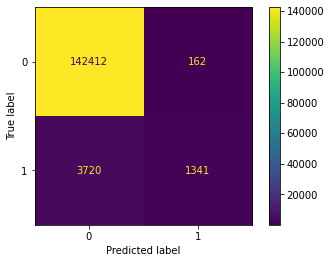

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142574
           1       0.89      0.26      0.41      5061

    accuracy                           0.97    147635
   macro avg       0.93      0.63      0.70    147635
weighted avg       0.97      0.97      0.97    147635



In [73]:
y_pred = cb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

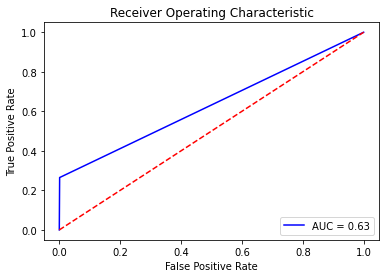

In [74]:
buildROC(y_test, y_pred)

Terrible Recall on this model. A Dummy variable that gueses no fraud every time would do just as well or even better

LGBM

In [75]:
import lightgbm as lgb

In [76]:
parameters = {
    'num_leaves': 256,
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'max_depth': 13,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0,
    'n_estimators':5000
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMClassifier(**parameters, n_jobs = -1)
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric='auc',
    verbose=False
)

C:\Users\JSPANGLER\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testi

LGBMClassifier(bagging_fraction=0.5, bagging_freq=20, boosting='gbdt',
               feature_fraction=0.5, is_unbalance='true', learning_rate=0.03,
               max_depth=13, metric='auc', n_estimators=5000, num_leaves=256,
               objective='binary', verbose=0)

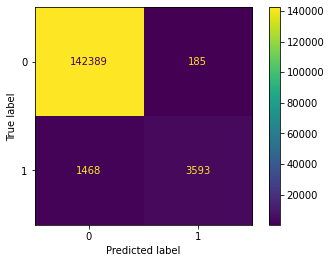

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    142574
           1       0.95      0.71      0.81      5061

    accuracy                           0.99    147635
   macro avg       0.97      0.85      0.90    147635
weighted avg       0.99      0.99      0.99    147635



In [77]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

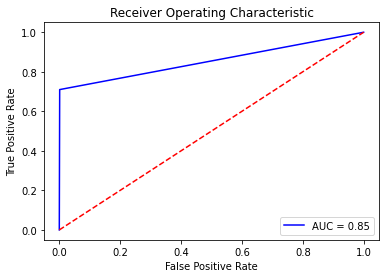

In [78]:
buildROC(y_test, y_pred)